- Be sure current working directory is 'demo/' folder:

In [5]:
import os
os.getcwd()

'/home/bohbot/Evyatar/git/Mosquito_Supermodel/src/playground'

- Import required functions:

In [6]:
from sahi.slicing import slice_coco
from sahi.utils.file import load_json

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os
import glob
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import shutil
import multiprocessing
from sahi.utils.coco import Coco

import tempfile
from tqdm import tqdm
from dask import bag as db

import json
import cv2
import uuid

from pathlib import Path

from multiprocessing import Pool

### Optimized version

In [7]:
images_train_source = '/home/bohbot/ultralytics/datasets/mos/all_mos_new/images/train'
images_val_source = '/home/bohbot/ultralytics/datasets/mos/all_mos_new/images/val'
labels_train_source = '/home/bohbot/ultralytics/datasets/mos/all_mos_new/labels/train'
labels_val_source = '/home/bohbot/ultralytics/datasets/mos/all_mos_new/labels/val'

In [9]:
all_image_paths = (
    [image_path for image_path in glob.iglob(f"{images_train_source}/*") 
     if image_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))] +
    [image_path for image_path in glob.iglob(f"{images_val_source}/*") 
     if image_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))]
)

all_annots_paths = (
    [annot_path for annot_path in glob.iglob(f"{labels_train_source}/*") 
     if annot_path.endswith('txt')] +
    [annot_path for annot_path in glob.iglob(f"{labels_val_source}/*") 
     if annot_path.endswith('txt')]
)

In [13]:
annot_dict = {
    os.path.splitext(os.path.basename(annot_path))[0]: annot_path
    for annot_path in all_annots_paths if 'test' not in annot_path
}

image_annot_paths = [
    (image_path, annot_dict[os.path.splitext(os.path.basename(image_path))[0]])
    for image_path in all_image_paths
    if os.path.splitext(os.path.basename(image_path))[0] in annot_dict
]

len(image_annot_paths), image_annot_paths[:2]

(12734,
 [('/home/bohbot/ultralytics/datasets/mos/all_mos_new/images/train/cropped_CNCr2T_644.jpeg',
   '/home/bohbot/ultralytics/datasets/mos/all_mos_new/labels/train/cropped_CNCr2T_644.txt'),
  ('/home/bohbot/ultralytics/datasets/mos/all_mos_new/images/train/2023-07-16_12-34-51_cam3_frame_60.jpg',
   '/home/bohbot/ultralytics/datasets/mos/all_mos_new/labels/train/2023-07-16_12-34-51_cam3_frame_60.txt')])

In [14]:
def process_file(file_paths, large_files_dir):
    try:
        image_path, annot_path = file_paths

        if not os.path.exists(image_path) or not os.path.exists(annot_path):
            print(f"Missing file: {image_path} or {annot_path}")
            return

        with Image.open(image_path) as img:
            width, height = img.size
            if width > 1000 or height > 1000:
                shutil.copy(image_path, large_files_dir)
                shutil.copy(annot_path, large_files_dir)
            else:
                return
    except Exception as e:
        print(f"Error processing {file_paths}: {e}")


def copy_list(image_annot_paths, large_files_dir):
    os.makedirs(large_files_dir, exist_ok=True)
    copied_count = 0
    for file_paths in tqdm(image_annot_paths):
        process_file(file_paths, large_files_dir)
        copied_count += 1
    print(f"Total files copied: {copied_count}")

def copy_large_images(image_annot_paths, large_files_dir):
    copied_count = 0
    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()-2) as executor:
        results = list(executor.map(
            lambda x: process_file(x, large_files_dir),
            image_annot_paths
        ))
    print(f"Total files copied: {copied_count}")


In [15]:
source_directory_or_paths = image_annot_paths # folder with both images and txt files
# large_files_directory = '/home/bohbot/Evyatar/git/crop_sahi/large_files' # copies only the large images to a different folder
batch_output_directory = '/home/bohbot/Evyatar/git/crop_sahi/large_images/images' # where to save the crops

In [ ]:
copy_list(image_annot_paths, batch_output_directory)

## 1. convert yolo annotations to coco

In [205]:
def process_image(args):
    image_filename, images_dir, yolo_annotations_dir = args[:3]
    category_mapping = args[3]

    image_path = os.path.join(images_dir, image_filename)
    annotation_filename = os.path.splitext(image_filename)[0] + ".txt"
    annotation_path = os.path.join(yolo_annotations_dir, annotation_filename)

    if not os.path.exists(annotation_path):
        return None, None, None

    image = cv2.imread(image_path)
    if image is None:
        return None, None, None

    height, width, _ = image.shape
    image_id = hash(image_filename)

    image_data = {
        "id": image_id,
        "file_name": image_filename,
        "height": height,
        "width": width
    }

    annotations = []
    categories = []

    with open(annotation_path, "r") as f:
        for line in f:
            line_data = line.strip().split()
            if len(line_data) < 5:
                continue

            category_id = int(line_data[0])
            x_center, y_center, bbox_width, bbox_height = map(float, line_data[1:])

            if category_id not in category_mapping:
                category_mapping[category_id] = f"category_{category_id}"
                categories.append({
                    "id": category_id,
                    "name": category_mapping[category_id],
                    "supercategory": "none"
                })

            x_min = (x_center - bbox_width / 2) * width
            y_min = (y_center - bbox_height / 2) * height
            bbox_width *= width
            bbox_height *= height

            annotations.append({
                "id": len(annotations) + 1,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [x_min, y_min, bbox_width, bbox_height],
                "area": bbox_width * bbox_height,
                "iscrowd": 0
            })

    return annotations, image_data, categories


def convert_yolo_to_coco(yolo_annotations_dir, images_dir, output_json_path):
    os.makedirs(output_json_path, exist_ok=True)
    coco_format = {"images": [], "categories": [], "annotations": []}
    category_mapping = {}

    image_filenames = [
        f for f in os.listdir(images_dir)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]

    args = [
        (image_filename, images_dir, yolo_annotations_dir, category_mapping)
        for image_filename in image_filenames
    ]

    with Pool(processes=os.cpu_count()-2) as pool:
        results = list(
            tqdm(pool.imap(process_image, args), total=len(args), desc="Processing images")
        )

    for annotations, image_data, categories in results:
        if annotations and image_data:
            coco_format["annotations"].extend(annotations)
            coco_format["images"].append(image_data)
        if categories:
            coco_format["categories"].extend(categories)

    category_ids = set()
    unique_categories = []
    for category in coco_format["categories"]:
        if category["id"] not in category_ids:
            category_ids.add(category["id"])
            unique_categories.append(category)
    coco_format["categories"] = unique_categories

    with open(f"{output_json_path}/coco_annotations.json", "w") as json_file:
        json.dump(coco_format, json_file, indent=4)

In [16]:
coco_annotations_path = f"{batch_output_directory.replace('/images','/coco')}"
sliced_images_path = f"{batch_output_directory.replace('/images','/sliced')}"
temp_image_dir = f"{batch_output_directory.replace('/images','/temp_processing')}"
yolo_format_dir = f"{batch_output_directory.replace('/images','/yolo_format')}"

In [ ]:
convert_yolo_to_coco(batch_output_directory, batch_output_directory, coco_annotations_path)

## 2. Slicing COCO Dataset into Grids

- To slice a COCO dataset annoations an images, we need to specify slice parameters. In this example we will ice images into 256x256 grids overlap ratio of 0.2:

In [17]:
n_files = len(glob.glob(f"{batch_output_directory}/*txt"))
n_files

11653

In [18]:
batch = n_files
json_out =f"{coco_annotations_path}/coco_annotations.json"
sliced_dir = sliced_images_path

In [190]:
def split_coco(coco_path):
    with open(coco_path, "r") as f:
        data = json.load(f)
    m = {}
    for img in data["images"]:
        m[img["file_name"]] = {
            "images": [img],
            "annotations": [],
            "categories": data.get("categories", [])
        }
    d = {img["id"]: img["file_name"] for img in data["images"]}
    for ann in data["annotations"]:
        fn = d[ann["image_id"]]
        m[fn]["annotations"].append(ann)
    return m

def process_file(args):
    f, splitted, sliced_dir = args
    name = Path(f).name
    if name not in splitted:
        return f
    o = os.path.join(sliced_dir, Path(f).stem)
    a = os.path.join(o, f"{Path(f).stem}_sliced_annotations.json")
    if os.path.exists(o) and os.path.exists(a):
        return None
    t = os.path.join(sliced_dir, f"temp_processing_{uuid.uuid4()}")
    try:
        os.makedirs(t, exist_ok=True)
        local_coco = os.path.join(t, "annotation.json")
        with open(local_coco, "w") as w:
            json.dump(splitted[name], w)
        shutil.copy(f, t)
        slice_coco(
            coco_annotation_file_path=local_coco,
            image_dir=t,
            output_coco_annotation_file_name=f"{Path(f).stem}_sliced_annotations",
            ignore_negative_samples=False,
            output_dir=o,
            slice_height=640,
            slice_width=640,
            overlap_height_ratio=0.2,
            overlap_width_ratio=0.2,
            min_area_ratio=0.1,
            verbose=False
        )
    except Exception:
        return f
    finally:
        if os.path.exists(t):
            shutil.rmtree(t)
    return None

def run_processing(batch_output_directory, sliced_dir, coco_file, processes=4):
    splitted = split_coco(coco_file)
    image_files = [
        x for x in glob.iglob(os.path.join(batch_output_directory, "*"))
        if not x.lower().endswith(".txt")
    ]
    with Pool(processes=processes) as p:
        r = p.map(
            process_file,
            [(f, splitted, sliced_dir) for f in image_files]
        )
    m = [x for x in r if x]
    if m:
        with open("missing_files.log", "w") as w:
            w.write("\n".join(m))
    return m

In [ ]:
missing_files = run_processing(
    batch_output_directory,
    sliced_dir,
    json_out,
    processes=os.cpu_count()-3
)

In [19]:
sliced_dir

'/home/bohbot/Evyatar/git/crop_sahi/large_images/sliced'

- Convert back to yolo

In [210]:
def _process_folder(args):
    folder_name, batch_output_directory, source_directory = args
    batch_path = os.path.join(batch_output_directory, folder_name)
    if not os.path.isdir(batch_path):
        return
    sliced_coco_path = os.path.join(
        batch_path, f"{os.path.basename(batch_path)}_sliced_annotations_coco.json"
    )
    if not os.path.exists(sliced_coco_path):
        return
    coco = Coco.from_coco_dict_or_path(sliced_coco_path, image_dir=batch_path)
    coco.export_as_yolov5(
        output_dir=source_directory,
        train_split_rate=1,
        disable_symlink=True
    )

def export_all_sliced_to_yolo(batch_output_directory, source_directory, processes=4):
    folders = sorted(os.listdir(batch_output_directory))
    with Pool(processes=processes) as pool:
        pool.map(
            _process_folder,
            [(f, batch_output_directory, source_directory) for f in folders]
        )

In [ ]:
export_all_sliced_to_yolo(sliced_dir, yolo_format_dir, processes=os.cpu_count()-5)

indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...


indexing coco dataset annotations...

indexing coco dataset annotations...
indexing coco dataset annotations...indexing coco dataset annotations...
indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/48 [00:00<?, ?it/s]

indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...
indexing coco dataset annotations...
indexing coco dataset annotations...

indexing coco dataset annotations...indexing coco dataset annotations...indexing coco dataset annotations...


indexing coco dataset annotations...
indexing coco dataset annotations...




Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]




indexing coco dataset annotations...

indexing coco dataset annotations...




Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 860.17it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 356.34it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 513.27it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.20it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.19it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotat

indexing coco dataset annotations...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 343.12it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 319.83it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.50it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 187.62it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.41it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 323.17it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 243.32it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 256.46it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 242.89it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 243.31it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 445.56it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 277.62it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 259.91it/s]


100%|██████████| 8/8 [00:00<00:00, 255.96it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 246.60it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 180.30it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 403.59it/s]


100%|██████████| 6/6 [00:00<00:00, 171.90it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 245.31it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.59it/s]


indexing coco dataset annotations...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


100%|██████████| 6/6 [00:00<00:00, 147.44it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 266.25it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 264.24it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 275.36it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 365.74it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 166.81it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 643.77it/s]

indexing coco dataset annotations...


01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1742.89it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.67it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 267.46it/s]


indexing coco dataset annotations...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 339.63it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.47it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 237.22it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 173.78it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 226.64it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 222.34it/s]
01/23/2025 1

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 197.17it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 378.75it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 282.43it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 262.99it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 457.89it/s]


100%|██████████| 6/6 [00:00<00:00, 209.58it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 266.97it/s]


indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 187.47it/s]

indexing coco dataset annotations...



  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 288.01it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 200.76it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 306.15it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 285.93it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 458.79it/s]

indexing coco dataset annotations...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 195.55it/s]

indexing coco dataset annotations...

100%|██████████| 48/48 [00:00<00:00, 822.21it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]    | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.42it/s]

indexing coco dataset annotations...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 228.15it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 186.96it/s]


01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 603.07it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.66it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.39it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 400.54it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 146.88it/s]


01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 303.02it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.79it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.29it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 617.07it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.55it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annot

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 355.60it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 390.96it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 213.14it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 399.71it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 216.21it/s]01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 196.43it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.91it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 298.61it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 241.61it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 200.76it/s]

indexing coco dataset annotations...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]    | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 258.42it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 265.73it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 228.98it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 514.87it/s]

indexing coco dataset annotations...

01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 188.23it/s]
01/23/2025 13:15:20 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 194.37it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 591.95it/s]


100%|██████████| 8/8 [00:00<00:00, 252.95it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 177.62it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 456.61it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 200.03it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 195.10it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 202.56it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.88it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 356.00it/s]01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 324.19it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.73it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 473.97it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 265.76it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.45it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.33it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 177.17it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 233.22it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 187.92it/s]
01/23/2025 1

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.02it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 323.05it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.69it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 348.30it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.97it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.97it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 248.77it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.47it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 254.53it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 187.55it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1536.29it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 183.03it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 270.79it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 275.03it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 185.73it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 246.54it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 223.75it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 283.33it/s]


indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 212.85it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 258.93it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/48 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 245.94it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.94it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 156.99it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.74it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.98it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.38it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 314.11it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.80it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.74it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.80it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.55it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 314.13it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.74it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.28it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.37it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.07it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.51it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 193.48it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.51it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 229.58it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 215.77it/s]


100%|██████████| 8/8 [00:00<00:00, 263.39it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.14it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 345.96it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.69it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.05it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 269.16it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 259.64it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.25it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 372.80it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1666.98it/s]


indexing coco dataset annotations...


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 264.79it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 258.35it/s]


100%|██████████| 6/6 [00:00<00:00, 213.28it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.74it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 175.45it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 427.41it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 178.78it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 188.08it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 198.43it/s]

indexing coco dataset annotations...



01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 184.58it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.90it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.84it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.07it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.83it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.96it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.92it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.64it/s]

indexing coco dataset annotations...



01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 284.58it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 143.67it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.48it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 266.56it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.94it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 204.97it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 143.40it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 159.82it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.33it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 200.62it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.78it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 186.39it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.76it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 250.05it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.49it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 241.83it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 220.99it/s]


100%|██████████| 8/8 [00:00<00:00, 266.25it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 410.31it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 236.36it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 244.55it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 256.90it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 535.08it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 229.81it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.17it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 268.45it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 257.93it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 225.96it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1781.78it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.49it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.32it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.62it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.86it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.51it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 522.07it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 282.49it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.22it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 582.40it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.55it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 619.44it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 318.08it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.84it/s]


indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.32it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 123.48it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 203.64it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 213.65it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 227.17it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 252.68it/s]
01/23/2025 1

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.60it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.22it/s]01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 274.18it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 311.00it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 397.47it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 301.53it/s]


100%|██████████| 8/8 [00:00<00:00, 273.41it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 258.33it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 195.15it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 371.53it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 219.06it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.62it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 150.39it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 473.89it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 731.26it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 162.16it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 272.00it/s]


indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 185.82it/s]01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 290.40it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 389.89it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 196.89it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.71it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 193.53it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.55it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.18it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 186.47it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 303.66it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 152.22it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.21it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 273.73it/s]


100%|██████████| 8/8 [00:00<00:00, 246.28it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 279.56it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 252.29it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.71it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 272.57it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 215.36it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.47it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 221.60it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 168.16it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 173.58it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.31it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 161.30it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 154.95it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 208.09it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 198.40it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.17it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 229.53it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 255.75it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 205.38it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 275.14it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 537.36it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.33it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 290.00it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.94it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 253.72it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 389.62it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 228.70it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 653.53it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 350.49it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 216.40it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 390.25it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 284.12it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 325.75it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 232.86it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 326.24it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.93it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 284.87it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 207.99it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 301.47it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 312.10it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 597.69it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.51it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.91it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 221.44it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.63it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.48it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 311.93it/s]


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 491.06it/s]01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 202.12it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.22it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.59it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.74it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 319.45it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 160.02it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.41it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 226.66it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.78it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.80it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.48it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 204.21it/s]01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 212.73it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 191.02it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 283.60it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 240.91it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 477.71it/s]


100%|██████████| 8/8 [00:00<00:00, 279.16it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.25it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.95it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.03it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 211.79it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 199.92it/s]

indexing coco dataset annotations...



01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 344.04it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 246.66it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 345.85it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 253.22it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 276.74it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 279.40it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.32it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 590.13it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.14it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 223.95it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 168.50it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.41it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.08it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 213.83it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 252.55it/s]01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 179.80it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.50it/s]


01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.42it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.80it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.79it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 476.88it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.33it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 471.59it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 272.66it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 258.92it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 182.74it/s]

indexing coco dataset annotations...

01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 668.57it/s]
01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 268.77it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 164.84it/s]

indexing coco dataset annotations...



01/23/2025 13:15:21 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.06it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 168.57it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 240.57it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 373.32it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 297.96it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 296.44it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.60it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 192.07it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 186.88it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 242.18it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 244.27it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 264.88it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 615.03it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 268.57it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 257.41it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 184.23it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.44it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.36it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.21it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.31it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 864.49it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.08it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 237.23it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 180.85it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 358.38it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 303.34it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.02it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 115.65it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 419.57it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 202.96it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 583.23it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.27it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 544.00it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 277.69it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 207.36it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 326.05it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 338.30it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 228.68it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 249.60it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.15it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 270.59it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 301.08it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 299.41it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.44it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.69it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 242.49it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 187.91it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 245.42it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.27it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 193.80it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 257.38it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 261.59it/s]


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.08it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.62it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 230.82it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.93it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 280.92it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 481.72it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 360.32it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 357.08it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 658.41it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 305.40it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 237.07it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.07it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.59it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.72it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 184.47it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 175.73it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 220.34it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 122.33it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 215.98it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 478.54it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 186.72it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 163.92it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 221.31it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 153.17it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 121.03it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.88it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.95it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 250.61it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 202.91it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 511.59it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 539.60it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 344.97it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 207.60it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 317.34it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 256.88it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.55it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.02it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 264.59it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 219.15it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.99it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 607.32it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 264.02it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 364.00it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 629.85it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 160.18it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 211.93it/s]


indexing coco dataset annotations...


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 415.07it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.02it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 154.27it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.65it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 254.72it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.41it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 425.80it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 424.03it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 194.79it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 119.99it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 237.92it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 185.73it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 156.45it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.81it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 154.64it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 207.03it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.29it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 204.66it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.36it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 166.68it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 205.56it/s]

indexing coco dataset annotations...



  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 164.56it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 188.76it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 435.33it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 571.07it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 235.76it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 250.69it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 172.95it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 314.35it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 268.30it/s]


indexing coco dataset annotations...
indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 274.69it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.59it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 195.73it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 184.60it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.54it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 306.30it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 188.60it/s]


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.89it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 255.18it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 168.44it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 136.40it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 448.49it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 233.89it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 415.48it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 416.46it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 227.26it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 261.36it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 178.83it/s]
01/23/2025 1

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.71it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.85it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.13it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.62it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.92it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.32it/s]

indexing coco dataset annotations...



01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 255.80it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 815.08it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 286.82it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 414.47it/s]


100%|██████████| 8/8 [00:00<00:00, 143.77it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 669.67it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 364.07it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 370.07it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 318.36it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 263.90it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 351.62it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 261.71it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 565.95it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.67it/s]

indexing coco dataset annotations...



01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.16it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 301.06it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.71it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 505.20it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 200.35it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.64it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.96it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 197.95it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.90it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.51it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 198.81it/s]


01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 242.75it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.16it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.27it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.36it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 224.42it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 258.13it/s]01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.99it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.99it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.74it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.49it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 357.24it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 250.84it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 217.21it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.18it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 294.48it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 498.03it/s]

indexing coco dataset annotations...



01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 204.35it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.63it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 212.07it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 243.20it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 366.99it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 148.58it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.37it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 283.36it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 247.59it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 224.49it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 254.67it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.98it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 223.71it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 183.92it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 245.88it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 462.74it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.74it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 154.58it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 246.91it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 179.91it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 597.44it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.64it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 2435.92it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.16it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and ann

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 135.88it/s]

indexing coco dataset annotations...



01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 263.48it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.35it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 343.84it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 267.65it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 184.22it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 181.30it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 233.13it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 215.89it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 205.24it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 547.64it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 275.86it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 439.06it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 173.75it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 420.56it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 135.68it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.64it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 142.76it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 341.83it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 195.26it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 246.40it/s]


100%|██████████| 8/8 [00:00<00:00, 126.19it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 167.81it/s]

indexing coco dataset annotations...

01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.82it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.76it/s]
01/23/2025 13:15:22 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 166.60it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 248.81it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 191.21it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 195.07it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 383.01it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.51it/s]


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 195.84it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.77it/s]


indexing coco dataset annotations...


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.86it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.04it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 151.93it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 211.87it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.76it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 216.69it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.79it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 243.71it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.34it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 148.23it/s]

indexing coco dataset annotations...



01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.33it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.92it/s]


indexing coco dataset annotations...


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 272.36it/s]

indexing coco dataset annotations...



01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.85it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.64it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 4985.80it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 309.39it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 202.61it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1583.07it/s]

indexing coco dataset annotations...



01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 210.52it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.47it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 306.85it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 197.55it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 250.29it/s]


100%|██████████| 6/6 [00:00<00:00, 230.51it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.18it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 233.20it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 279.23it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 807.08it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 379.84it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.99it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 205.94it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 116.87it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 222.86it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.23it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 260.62it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.74it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.39it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.95it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 229.39it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 48/48 [00:00<00:00, 991.25it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 303.89it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 351.75it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 282.55it/s]01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 6/6 [00:00<00:00, 188.43it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.25it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 337.09it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 370.22it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 348.99it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 338.47it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.77it/s]
01/23/2025 1

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 225.09it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 228.78it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.16it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 193.39it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 205.10it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 175.83it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1490.17it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 173.34it/s]01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 172.22it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 168.69it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.31it/s]


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/48 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 235.44it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.92it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 283.85it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 298.52it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.80it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 235.12it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.23it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.40it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 213.63it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.09it/s]


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 195.80it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 138.74it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 236.37it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 206.18it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.33it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 229.63it/s]01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 171.52it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.86it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 272.22it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.34it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 497.99it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.96it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 288.71it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 590.57it/s]


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.83it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.53it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/48 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.49it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 283.11it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.53it/s]


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 345.62it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.15it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 260.54it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 299.76it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 209.86it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 213.77it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1540.43it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 160.61it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.35it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 191.41it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.05it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 325.90it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 321.02it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 442.69it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 191.40it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 202.27it/s]


indexing coco dataset annotations...


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.16it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.17it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 347.77it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 213.95it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.59it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 226.75it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.35it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 422.48it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.55it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 185.37it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.17it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 177.10it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 393.87it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 48/48 [00:00<00:00, 1122.95it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 563.04it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.46it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.29it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.31it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 256.54it/s]01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.53it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 232.19it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 146.87it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 180.74it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.09it/s]


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 432.01it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 182.70it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 190.60it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 134.11it/s]01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 427.52it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 235.29it/s]


indexing coco dataset annotations...
indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 227.39it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 226.90it/s]


indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 213.37it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 222.67it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 253.43it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.43it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.61it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.61it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 251.09it/s]01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1493.14it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and ann

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.67it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 263.52it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 561.51it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.80it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.58it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 668.11it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 286.84it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 404.34it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 213.92it/s]


01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 205.23it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.87it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.98it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.59it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 290.25it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.98it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.28it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 205.46it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.45it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 319.45it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 309.12it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 189.11it/s]

indexing coco dataset annotations...

100%|██████████| 48/48 [00:00<00:00, 992.08it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.92it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 124.27it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 253.57it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.67it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 314.07it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 143.64it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 245.09it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 352.91it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.68it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.28it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 185.41it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.13it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 527.57it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 243.33it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 138.21it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.12it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 380.45it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 273.15it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 136.84it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.59it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 172.04it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 247.46it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.13it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 186.02it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 380.46it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 162.39it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 221.55it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 134.41it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 164.60it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 182.21it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 114.72it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.31it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 160.37it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 338.43it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 159.49it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 213.87it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 213.42it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.15it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 342.62it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 4230.97it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 337.33it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.40it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.22it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 213.26it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 280.56it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 550.74it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 280.42it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.90it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 394.58it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.96it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 700.51it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.77it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.87it/s]
01/23/2025 1

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 196.80it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 286.04it/s]


100%|██████████| 8/8 [00:00<00:00, 244.08it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 399.02it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 172.21it/s]01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 272.36it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.25it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 164.30it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 149.84it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 198.58it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 612.12it/s]

indexing coco dataset annotations...

01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 286.63it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.99it/s]
01/23/2025 13:15:23 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 255.13it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 230.09it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.60it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 192.31it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 194.16it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.96it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.40it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.80it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 177.31it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 245.42it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 149.07it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.50it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.55it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 189.62it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.70it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.84it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.14it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 246.01it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.88it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.26it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.34it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 267.13it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.57it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.65it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 213.81it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.42it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.49it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 164.37it/s]

indexing coco dataset annotations...



100%|██████████| 6/6 [00:00<00:00, 173.26it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 176.15it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.82it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 298.62it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 163.95it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.35it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 267.74it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 309.80it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 252.99it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.05it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 237.31it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.12it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 489.02it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.96it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 544.35it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 192.54it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.91it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.11it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 211.95it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 202.50it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 381.06it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 336.17it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.87it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 450.26it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 212.81it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 573.38it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.86it/s]01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 657.29it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.70it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.19it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 534.03it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.05it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 233.56it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 458.49it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 401.34it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 199.73it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 170.59it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 221.49it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 305.78it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 164.77it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 148.56it/s]


100%|██████████| 8/8 [00:00<00:00, 148.49it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 488.05it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 447.73it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.62it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 453.13it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 483.50it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 249.34it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 105.65it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 116.11it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.04it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 104.41it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 118.82it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.75it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.68it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.65it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 105.79it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 112.53it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 117.91it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.40it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 387.63it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 243.27it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.24it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 145.46it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 380.64it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 197.00it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 151.21it/s]

indexing coco dataset annotations...


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 438.90it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.62it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 253.55it/s]


indexing coco dataset annotations...


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 163.36it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.71it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 136.63it/s]01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 244.57it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 237.48it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 184.90it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 178.78it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 113.94it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 369.69it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 185.90it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 338.66it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.39it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 258.86it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 215.72it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.10it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 211.93it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 171.14it/s]


100%|██████████| 6/6 [00:00<00:00, 165.60it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.50it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.07it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.07it/s]01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 197.19it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 454.87it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 479.68it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 122.88it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 134.92it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 142.46it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 129.24it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.52it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 242.29it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.02it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 241.29it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 134.83it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 148.11it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 196.27it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 119.06it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 179.53it/s]


100%|██████████| 8/8 [00:00<00:00, 199.27it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 256.41it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.71it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 196.18it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.49it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 244.38it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 237.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 171.81it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 283.98it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 258.98it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.52it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.81it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 209.30it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 182.98it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 562.23it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 104.76it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.15it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.36it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 198.21it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 205.14it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 172.65it/s]


100%|██████████| 6/6 [00:00<00:00, 176.06it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 157.84it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 216.23it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 248.75it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 176.76it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 752.04it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.26it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 341.06it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.07it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 323.23it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.76it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.46it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 326.90it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 141.10it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 812.00it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 158.40it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 360.37it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 245.60it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.63it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 123.08it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 474.27it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 349.69it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.84it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.50it/s]

indexing coco dataset annotations...



01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.54it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.51it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 87.11it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.55it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 250.18it/s]01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 254.18it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.72it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 273.86it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 187.00it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 276.92it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 197.14it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 254.83it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 303.89it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 423.37it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 196.87it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 225.02it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 323.95it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.49it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 380.15it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 343.77it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 341.28it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.36it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 227.82it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 229.96it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 216.91it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.35it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.76it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.78it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 180.19it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 242.99it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.44it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.82it/s]


01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.37it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 102.41it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 421.48it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 469.75it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 125.52it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 188.08it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 161.51it/s]

indexing coco dataset annotations...

01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 155.93it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 230.52it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 237.77it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 389.53it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 150.25it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 590.52it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 149.36it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 188.10it/s]01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 196.60it/s]
01/23/2025 13:15:24 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 267.42it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 205.30it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.82it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 248.09it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 407.70it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 223.93it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.81it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 223.72it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.88it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 218.89it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 264.62it/s]
01/23/2025 1

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.50it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 258.91it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.10it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 284.43it/s]

indexing coco dataset annotations...



01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.57it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 186.37it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 376.99it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.46it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 246.22it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.98it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 302.21it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 221.01it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 206.18it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 192.62it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 208.16it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 204.00it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 310.32it/s]


100%|██████████| 8/8 [00:00<00:00, 448.25it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.19it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 393.70it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 159.41it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 235.82it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 258.19it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 616.66it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 344.06it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.89it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 234.78it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.50it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 284.28it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.37it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.76it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 192.17it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 185.77it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 254.74it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 159.24it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 183.35it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 268.58it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 309.89it/s]


100%|██████████| 8/8 [00:00<00:00, 257.92it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 258.02it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 767.17it/s]

indexing coco dataset annotations...



01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 300.33it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 290.80it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 318.27it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 280.37it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 235.93it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 379.71it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 247.67it/s]

indexing coco dataset annotations...



01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 324.46it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 262.45it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 196.29it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 246.93it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 253.44it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 255.69it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 256.84it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 184.61it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 145.71it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.19it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.59it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 141.99it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.20it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 256.91it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.57it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 459.20it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 227.78it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.36it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.16it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 191.31it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 417.73it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.00it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 320.67it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 327.16it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.18it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 256.56it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 257.26it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 367.37it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 217.93it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 845.20it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.24it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 254.09it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 271.66it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.96it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 252.17it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 200.24it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 240.86it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 248.52it/s]


100%|██████████| 8/8 [00:00<00:00, 346.77it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 190.52it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.43it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.08it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 146.64it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.53it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.42it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.65it/s]

indexing coco dataset annotations...



01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 243.43it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 312.54it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 280.76it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 349.06it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 907.76it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 249.81it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.95it/s]
01/23/2025 1

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 622.66it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 216.86it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.69it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.02it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.79it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 235.88it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 596.78it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 227.41it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.94it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.58it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 268.71it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 204.43it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.57it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 613.82it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.19it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 255.71it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 247.98it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.73it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 422.34it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 176.43it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 160.34it/s]


100%|██████████| 8/8 [00:00<00:00, 206.38it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 201.12it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 165.10it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 503.74it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 140.85it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 185.81it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 147.27it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 116.05it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 157.53it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 337.98it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.84it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 216.65it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 191.01it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 212.38it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.14it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 142.77it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 246.40it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 180.74it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 172.64it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.01it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 220.76it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 216.17it/s]
01/23/2025 1

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 173.42it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 286.23it/s]

indexing coco dataset annotations...



  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 290.82it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.92it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 382.98it/s]

indexing coco dataset annotations...



  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 205.60it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 186.69it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.66it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.86it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 176.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 174.70it/s]


indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


100%|██████████| 8/8 [00:00<00:00, 219.21it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 215.12it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 284.13it/s]


indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


100%|██████████| 6/6 [00:00<00:00, 154.16it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 162.78it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 207.97it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 474.80it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 216.80it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 207.52it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 217.03it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 381.72it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.41it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 304.37it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 305.91it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.05it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.24it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 260.05it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.75it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.29it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 192.33it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 196.78it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.50it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 176.95it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 210.52it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 222.18it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 327.87it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 227.14it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 204.13it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 401.53it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 267.15it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 376.08it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 354.39it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.78it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 272.70it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.94it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.65it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 252.16it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 217.25it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.60it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.26it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 270.23it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.13it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 309.22it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.60it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 242.60it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...



indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.37it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 341.40it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 348.70it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 234.28it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 282.94it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 354.89it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 231.93it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.80it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.34it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.09it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 318.02it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 236.36it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 139.27it/s]

indexing coco dataset annotations...

01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 446.10it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 191.43it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 230.01it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.01it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 278.74it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...



indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 160.81it/s]


01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.73it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 171.29it/s]01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 268.95it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 200.10it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 253.05it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 193.76it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 249.20it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 268.99it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 267.44it/s]

indexing coco dataset annotations...



  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.63it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 186.54it/s]
01/23/2025 13:15:25 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.76it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 193.48it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 255.51it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 268.03it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.28it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 300.77it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.49it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 260.54it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 216.94it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 780.55it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.89it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 185.89it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 237.71it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.18it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 185.72it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.74it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.52it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.29it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 240.23it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 236.64it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 227.03it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 313.39it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 311.63it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.90it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.92it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.24it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.84it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.56it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 241.64it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 187.48it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.57it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.67it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 203.06it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 450.69it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 246.83it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 173.87it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.29it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.10it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.24it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 250.65it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.10it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 234.49it/s]


indexing coco dataset annotations...
indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 238.29it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 166.51it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 244.84it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 242.54it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.39it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 167.90it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 216.23it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 255.91it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 188.33it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 114.26it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 238.74it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 153.99it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 226.19it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 178.92it/s]


100%|██████████| 8/8 [00:00<00:00, 273.94it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 205.38it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 178.37it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.41it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 192.74it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 193.38it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.99it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.32it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.51it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.49it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 201.15it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.05it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.48it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.38it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 205.37it/s]

indexing coco dataset annotations...



  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.00it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 380.95it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 306.82it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 374.65it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.74it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.77it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.37it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 272.47it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 399.43it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.23it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annot

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.44it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.64it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.35it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 280.83it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 246.68it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 253.36it/s]


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 265.28it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.58it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.22it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.48it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 253.03it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 380.67it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 169.32it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 223.84it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 221.54it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 160.87it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.14it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 229.99it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 235.90it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 191.75it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.42it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.72it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 211.47it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 354.43it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 305.83it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 213.08it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 233.50it/s]


100%|██████████| 6/6 [00:00<00:00, 226.91it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 577.16it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 309.60it/s]


100%|██████████| 6/6 [00:00<00:00, 213.28it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 594.33it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.94it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 202.93it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.34it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.94it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.24it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 157.71it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 283.12it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 330.60it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 262.71it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 161.16it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 273.55it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.50it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 265.62it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 195.68it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.28it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.57it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.36it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 309.93it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 306.94it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 214.51it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.07it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 155.66it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 255.26it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 196.36it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 443.52it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 560.04it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.86it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.08it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 357.93it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 347.94it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 258.00it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 241.66it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 366.12it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 309.98it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 232.77it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.79it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 323.13it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.41it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.93it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 227.27it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.82it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annot

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.85it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.63it/s]


indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 185.30it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.26it/s]


indexing coco dataset annotations...


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 222.71it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 220.23it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 251.85it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 202.15it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 232.86it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 236.18it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 184.47it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 367.80it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 223.92it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 208.51it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 215.05it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 235.22it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.24it/s]

indexing coco dataset annotations...



01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.12it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 164.69it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 181.41it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.14it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 205.81it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 6/6 [00:00<00:00, 294.79it/s]

indexing coco dataset annotations...



  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 238.90it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.91it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.22it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.08it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.83it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.37it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 251.43it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.76it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 224.63it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.86it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.31it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 195.07it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.13it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 248.10it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.11it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 265.04it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.33it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.11it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.89it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 255.00it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.04it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 247.18it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 230.04it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.71it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 308.36it/s]

indexing coco dataset annotations...



100%|██████████| 6/6 [00:00<00:00, 237.21it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.24it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 235.40it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 219.34it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.73it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 534.69it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 227.31it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 166.87it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.55it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.52it/s]


01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.01it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 205.73it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 366.46it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.73it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.30it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.49it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 133.00it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 215.94it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 161.45it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.82it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 254.36it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 650.72it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 211.00it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 209.42it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 241.28it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 131.93it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 205.53it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 427.11it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 256.84it/s]

indexing coco dataset annotations...



01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 170.04it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 234.28it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 238.43it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 287.40it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 141.67it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 223.94it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.79it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 226.89it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 494.16it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 215.33it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 224.93it/s]


100%|██████████| 8/8 [00:00<00:00, 240.16it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.17it/s]

indexing coco dataset annotations...

01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 136.63it/s]
01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.82it/s]


100%|██████████| 8/8 [00:00<00:00, 248.19it/s]01/23/2025 13:15:26 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 241.94it/s]


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.12it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.80it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 158.27it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 239.34it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 138.63it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.76it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 228.04it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 178.37it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 332.09it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 286.53it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 344.95it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.72it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 486.92it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 174.24it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.88it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 166.61it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 543.71it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 168.04it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 179.18it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.69it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 248.22it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 236.42it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 233.59it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 178.72it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.36it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 648.32it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 249.11it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.22it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.58it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 1038.29it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 265.19it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 345.59it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 370.68it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.92it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.96it/s]

indexing coco dataset annotations...



01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 208.72it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.54it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 244.30it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.16it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.76it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 258.96it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 247.00it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 168.41it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.70it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 6788.73it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 140.43it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 174.51it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 180.74it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 244.83it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.92it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 275.26it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 198.80it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 269.46it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 248.18it/s]

indexing coco dataset annotations...



01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 348.55it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 289.19it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.82it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 206.43it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.01it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.45it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 283.68it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 271.00it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 203.27it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.88it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.42it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 351.20it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 141.38it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 663.85it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 200.96it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.32it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.37it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.98it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 269.80it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 223.46it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.22it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.04it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 278.04it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 275.17it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.47it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 186.16it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 694.49it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 260.27it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 367.92it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 382.25it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 209.34it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 296.84it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 407.63it/s]
01/23/2025 1

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 398.67it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.00it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.11it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.16it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 162.81it/s]

indexing coco dataset annotations...



01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 330.92it/s]


indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.57it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 166.88it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...



indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 228.98it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 175.21it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 247.84it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 305.64it/s]


100%|██████████| 8/8 [00:00<00:00, 300.50it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 249.54it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 326.97it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.67it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 408.81it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 267.02it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 198.05it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 244.86it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 180.06it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 181.63it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.48it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 476.04it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 190.28it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.73it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 210.18it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 298.15it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 180.41it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 279.07it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.60it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 379.89it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 345.70it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 236.75it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 319.47it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 318.17it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.43it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 170.85it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 226.26it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.83it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.44it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.19it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 304.34it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 148.14it/s]

indexing coco dataset annotations...



01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.13it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.15it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 299.93it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 272.45it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 249.80it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 327.91it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 394.16it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.89it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 254.76it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 246.96it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 165.88it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 446.84it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.34it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 280.85it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.50it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 254.23it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 257.02it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 195.62it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.62it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 237.09it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 258.67it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 223.15it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 152.47it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 145.31it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 143.84it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 387.07it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 180.08it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 268.60it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 106.99it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 152.19it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 148.21it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 201.01it/s]

indexing coco dataset annotations...



01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 193.83it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 199.64it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 198.18it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 155.02it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 241.07it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annot

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 209.76it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 206.42it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 230.88it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 217.92it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 395.46it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 326.59it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 355.53it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 176.78it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 212.82it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 359.26it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.66it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 255.16it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 762.98it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 420.00it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 235.83it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 176.97it/s]01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 132.74it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 163.01it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 149.53it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.79it/s]


01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 283.71it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 318.69it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.97it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.16it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 494.28it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 258.89it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 219.26it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.64it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 251.99it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 284.14it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.42it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.58it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 387.84it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 390.23it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.80it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 141.14it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 448.21it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 212.59it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 267.04it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 179.45it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 249.96it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.67it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.56it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 266.38it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 197.00it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 178.25it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 253.46it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 246.70it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.60it/s]

indexing coco dataset annotations...



01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.27it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 221.59it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.27it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 179.49it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.22it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.27it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 311.06it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 319.59it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.89it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 177.41it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 245.18it/s]


100%|██████████| 8/8 [00:00<00:00, 345.08it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.94it/s]

indexing coco dataset annotations...

01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 252.33it/s]
01/23/2025 13:15:27 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 336.81it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.53it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 182.29it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 228.06it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 141.88it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 153.16it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 221.54it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 166.31it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 231.33it/s]


Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1617.13it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 239.30it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.29it/s]

indexing coco dataset annotations...



01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.05it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 171.41it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.92it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 4277.72it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 202.43it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 198.77it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 174.38it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.34it/s]


indexing coco dataset annotations...


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 204.62it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 137.17it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 152.73it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 241.22it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.45it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.21it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.45it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.55it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 152.89it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 207.63it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 194.89it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 170.40it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 165.28it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 311.78it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 163.11it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 175.78it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 131.27it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 136.07it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 222.45it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 158.21it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 156.53it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 222.33it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 160.18it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 239.89it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 149.55it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 225.01it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 419.17it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 183.91it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 164.03it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 248.26it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 256.58it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.11it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 452.57it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.69it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 246.06it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 365.34it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 385.34it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 661.69it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 909.17it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 309.24it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 151.24it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.35it/s]


indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.94it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.70it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 193.75it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 272.63it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 234.94it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.05it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 355.13it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 285.75it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.03it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.93it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 148.60it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 209.28it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 782.10it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 294.95it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 287.28it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.39it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 259.30it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 175.72it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 130.09it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.97it/s]


indexing coco dataset annotations...


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 125.03it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 258.36it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 312.05it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 195.65it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 192.42it/s]



indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 202.12it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 140.69it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 177.70it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 166.84it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 126.40it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 99.29it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 140.03it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 214.15it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 165.56it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 176.64it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 226.29it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.04it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.73it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 159.84it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 321.76it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.95it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 282.54it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 223.13it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 312.62it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 306.22it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 462.90it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.92it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.23it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annot

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.83it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 183.02it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 435.82it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 273.28it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 272.07it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 201.80it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 253.59it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 203.74it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 182.92it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 261.18it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 488.81it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.81it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 345.48it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 245.38it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 247.28it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.23it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 230.81it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.44it/s]

indexing coco dataset annotations...



01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.71it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 236.00it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 229.41it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 594.26it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 367.87it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 337.27it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 343.52it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 254.15it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.35it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 221.73it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.53it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 156.74it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 191.82it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 256.69it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 253.74it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 249.61it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 200.03it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 283.56it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 253.50it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 189.39it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 248.30it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.89it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.77it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 148.13it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 391.39it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 8751.81it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.85it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.89it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 236.52it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.11it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 195.31it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 241.50it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 239.04it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 236.71it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 234.19it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.19it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.98it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 137.15it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.52it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.55it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.29it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 252.39it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 268.08it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 196.48it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.15it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.59it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.77it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.94it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.27it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 262.38it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...



indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 172.83it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.13it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 351.73it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 146.48it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 184.79it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 183.42it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 250.51it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.78it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 4594.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 283.68it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 193.75it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 263.19it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 517.03it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 188.14it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 186.62it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.55it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 274.03it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.77it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.07it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 186.95it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 187.10it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.25it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 279.94it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 225.52it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 216.69it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 237.85it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 252.52it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 238.02it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 174.84it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.88it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 337.41it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.07it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.52it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 249.66it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.44it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 837.42it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 292.86it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 310.49it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 311.10it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 242.77it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 365.02it/s]


01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.94it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.99it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 158.18it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 215.47it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 213.37it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.03it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 262.56it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 208.15it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 299.53it/s]01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 337.04it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 324.38it/s]
01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.25it/s]

indexing coco dataset annotations...

01/23/2025 13:15:28 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.84it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 533.61it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.55it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 252.35it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 208.35it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 239.27it/s]


indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 164.65it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 227.24it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 177.28it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 229.51it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 530.02it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 244.95it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.62it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.14it/s]

indexing coco dataset annotations...



01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.87it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 191.93it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.73it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 297.02it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.67it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.21it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 239.57it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 178.92it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 412.13it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 223.63it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 221.02it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 397.02it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.50it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.64it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 369.36it/s]

indexing coco dataset annotations...



01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 193.29it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 251.76it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 250.02it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 390.30it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 257.05it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 241.42it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 206.60it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.42it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.19it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 283.58it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.36it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.19it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.10it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 245.30it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 218.25it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 176.64it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 253.39it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 251.50it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 349.26it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 220.24it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.40it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 229.97it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 248.68it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 246.98it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.15it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 171.54it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 139.54it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 252.41it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.57it/s]

indexing coco dataset annotations...



01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.20it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.69it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 237.65it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 235.84it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 253.36it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.15it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.30it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 265.48it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 319.10it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 399.71it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.23it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 233.30it/s]

indexing coco dataset annotations...



01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 187.03it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 234.27it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 389.79it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 269.45it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 208.49it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 359.39it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 295.16it/s]01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 326.68it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.77it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 192.16it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 230.56it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.72it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 417.03it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 227.71it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.81it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.03it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.09it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 480.21it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.94it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.57it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.31it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 213.84it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.59it/s]


indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 181.07it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 210.10it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 236.97it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 190.13it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 150.80it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 200.76it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.02it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.19it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 294.60it/s]01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...



indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 122.45it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.46it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 196.08it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 357.27it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 220.17it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.81it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 242.22it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 241.39it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 284.47it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 133.29it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 215.86it/s]


100%|██████████| 8/8 [00:00<00:00, 213.80it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 130.58it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 230.98it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 221.68it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.79it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 113.66it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 151.38it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 168.26it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 209.69it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 273.73it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.30it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 321.98it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 148.95it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 271.70it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 215.91it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 407.64it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 256.14it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 252.33it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.87it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 356.87it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 212.60it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.19it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 219.66it/s]01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.01it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 212.37it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 234.78it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 635.44it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 207.97it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.71it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 245.37it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 382.24it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.91it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.84it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 736.49it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 350.72it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.45it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 189.76it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 268.99it/s]

indexing coco dataset annotations...



  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 266.24it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.98it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 250.71it/s]01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 435.19it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 203.46it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 266.81it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 186.77it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 247.74it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 252.92it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 238.50it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 405.88it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 173.91it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.64it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 243.48it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 224.09it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 285.48it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.29it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 235.81it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 226.64it/s]


indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 248.46it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.46it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.02it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.48it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.74it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 346.78it/s]
01/23/2025 1

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 336.82it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 209.15it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 173.23it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 229.36it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 187.39it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 157.92it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 191.02it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 218.08it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 449.03it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 143.62it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 198.93it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 155.44it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 164.83it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 309.92it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 239.24it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 214.13it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 265.54it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 243.74it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 286.23it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 303.54it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 179.72it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 551.20it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.55it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.23it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 356.03it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 324.33it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.75it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.73it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 338.14it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 345.10it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.56it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.52it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 196.59it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 196.66it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.96it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.72it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 356.67it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.44it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annot

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 221.45it/s]


indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.19it/s]


01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 247.64it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 352.89it/s]01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 227.96it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 316.82it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 321.62it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 391.97it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 259.14it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 191.63it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 260.35it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 238.71it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 250.25it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 250.75it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 143.27it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 177.96it/s]


100%|██████████| 6/6 [00:00<00:00, 166.18it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 197.30it/s]

indexing coco dataset annotations...



100%|██████████| 6/6 [00:00<00:00, 190.66it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.96it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.04it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 153.11it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 366.73it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 186.40it/s]
01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.34it/s]

indexing coco dataset annotations...

01/23/2025 13:15:29 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.66it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.74it/s]


01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.90it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.03it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.56it/s]

indexing coco dataset annotations...



01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.52it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 267.09it/s]

indexing coco dataset annotations...



01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 185.30it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 355.08it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.83it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.57it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 471.40it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 169.56it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 115.90it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 141.35it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 138.85it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.28it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 224.58it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 204.44it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.08it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 247.96it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 279.64it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 226.38it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 186.06it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 215.27it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 214.44it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 217.69it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 168.50it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 165.18it/s]


indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 204.01it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 320.09it/s]


100%|██████████| 6/6 [00:00<00:00, 364.56it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.05it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 257.09it/s]

indexing coco dataset annotations...



01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.67it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.21it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 150.74it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.07it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 184.37it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 180.49it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 197.11it/s]01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 242.20it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.47it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 177.27it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.46it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 224.52it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.94it/s]01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 267.29it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 184.83it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.93it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 257.97it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 269.28it/s]01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.49it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.33it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 219.97it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.88it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 168.76it/s]


indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 173.50it/s]

indexing coco dataset annotations...



  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 371.19it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 236.16it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 235.16it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 395.67it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 162.13it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 219.09it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.34it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 241.40it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 339.64it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 664.54it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 304.27it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 162.54it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.65it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 275.28it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 255.53it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 258.06it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 246.37it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 183.35it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 246.46it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 181.34it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 750.10it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 195.99it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 194.91it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 218.96it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 366.47it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 193.27it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 205.35it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 234.10it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 500.87it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 287.27it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 286.40it/s]

indexing coco dataset annotations...



  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 326.55it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.69it/s]


01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 247.14it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 253.30it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.67it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.49it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 208.88it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 176.99it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 242.91it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 179.77it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 255.12it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 435.16it/s]


01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.13it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.80it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 319.46it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 268.48it/s]


01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 302.13it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 255.82it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 249.85it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 256.26it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 284.47it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.69it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 270.31it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 360.91it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.96it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.17it/s]


01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 326.69it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 430.53it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 290.02it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 204.39it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.92it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.84it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 186.36it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.71it/s]
01/23/2025 1

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 258.32it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.19it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 257.03it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 171.65it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 170.99it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 248.29it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 184.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 214.25it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 345.67it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 197.83it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 188.76it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 385.38it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 273.70it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 195.47it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 239.51it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 242.44it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 178.34it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 162.82it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 367.61it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 218.49it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 196.52it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 245.73it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 140.46it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 149.15it/s]01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.77it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 129.82it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 480.05it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 155.89it/s]01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 187.07it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 186.00it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 224.17it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 215.33it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 218.06it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 214.71it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 172.67it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 231.66it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 254.12it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 183.89it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 196.77it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 192.01it/s]

indexing coco dataset annotations...



  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.62it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 290.01it/s]

indexing coco dataset annotations...



100%|██████████| 8/8 [00:00<00:00, 315.25it/s]


indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 280.71it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 178.91it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 247.30it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 236.87it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.83it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.38it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 275.38it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 311.37it/s]

indexing coco dataset annotations...



01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.95it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 286.44it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.12it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 364.66it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 663.58it/s]

indexing coco dataset annotations...



01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 252.95it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 168.60it/s]01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 213.14it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 1912.81it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.80it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 175.71it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 378.94it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 363.63it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 266.67it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.99it/s]
01/23/2025 1

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 211.47it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 373.31it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 379.66it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 249.72it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 221.09it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 667.76it/s]


01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 235.32it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 140.56it/s]

indexing coco dataset annotations...



100%|██████████| 6/6 [00:00<00:00, 113.16it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 216.90it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 220.66it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 215.12it/s]

indexing coco dataset annotations...



01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 432.68it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 166.25it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 152.50it/s]


indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 258.10it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 179.88it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 3131.25it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 174.34it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 158.09it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 318.51it/s]


01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 169.61it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.91it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 257.00it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.02it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 461.73it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 207.22it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 498.79it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.95it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.05it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 247.78it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 149.42it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 450.15it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.13it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.94it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 199.90it/s]


indexing coco dataset annotations...
indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 269.72it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 155.57it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.43it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 295.24it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.16it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 364.94it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 234.04it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 186.49it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 265.60it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 183.48it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 330.84it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 231.40it/s]

indexing coco dataset annotations...

01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.99it/s]
01/23/2025 13:15:30 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 403.39it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 205.79it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.72it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.36it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 386.09it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 243.66it/s]


100%|██████████| 6/6 [00:00<00:00, 190.12it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 440.24it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 268.39it/s]01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 247.93it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 164.37it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 157.32it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 220.23it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 215.21it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 207.93it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 199.91it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 94.93it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.35it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 183.85it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 543.33it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 478.06it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 245.44it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 270.09it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 341.68it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 357.77it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.74it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 187.25it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.54it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.22it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 244.38it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 390.82it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.11it/s]01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.48it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 386.13it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.25it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 138.89it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 101.66it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 532.04it/s]

indexing coco dataset annotations...



01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 284.28it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 133.14it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 154.16it/s]01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 567.13it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 204.22it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.35it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 140.38it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 211.08it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 323.49it/s]

indexing coco dataset annotations...



01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 143.63it/s]


indexing coco dataset annotations...


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 324.64it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 189.66it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 187.20it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.61it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 265.19it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 195.79it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.14it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 313.84it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.18it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.34it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.36it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 236.78it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.01it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 229.65it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 280.33it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.99it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 273.91it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 209.55it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.75it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 186.95it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 202.64it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.50it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 198.45it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 261.29it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 265.55it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 186.66it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.99it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.52it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 223.34it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 224.64it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.41it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 240.33it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.76it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.33it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.62it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.23it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.54it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 168.12it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 420.54it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 216.75it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 160.51it/s]


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 132.54it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 92.25it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 224.99it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 104.16it/s]


indexing coco dataset annotations...


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 280.56it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 107.73it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 165.52it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 166.90it/s]

indexing coco dataset annotations...



01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.97it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 372.01it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 263.83it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 153.85it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 177.31it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 251.36it/s]01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 247.66it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.25it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.80it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.90it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.29it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.13it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.27it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 278.98it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.00it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.57it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 227.20it/s]


indexing coco dataset annotations...


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 279.56it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 229.29it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.56it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 275.66it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 500.16it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.50it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.94it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 309.35it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 216.55it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.46it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 197.38it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 212.81it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 402.20it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 197.54it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 303.30it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 246.37it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 240.24it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.98it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.50it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 196.08it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 189.15it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 264.19it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 249.86it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 223.87it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 285.10it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.79it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 211.47it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 144.72it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.59it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.44it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.99it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 138.38it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 182.59it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 227.44it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 220.68it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 243.26it/s]


indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 164.27it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 429.93it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 239.46it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 244.93it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 203.83it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 407.92it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 236.30it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 199.22it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 209.01it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 128.31it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 560.03it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 185.26it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 278.54it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 219.50it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 138.00it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 159.78it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.56it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 324.18it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 288.71it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 218.39it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 255.82it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 219.20it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 311.02it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 212.19it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.52it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.03it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 346.02it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 465.36it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 499.99it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 225.59it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 341.32it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 323.39it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 276.74it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 734.17it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 399.70it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 257.49it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 350.60it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.52it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 349.78it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 255.65it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 294.48it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 234.57it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.36it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 328.05it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 318.71it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 357.77it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 353.85it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 311.93it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.67it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 217.86it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.40it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.44it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 284.30it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 251.35it/s]

indexing coco dataset annotations...



01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 229.35it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 291.69it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.93it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 288.12it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 180.56it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 885.29it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 290.20it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.36it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.40it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.29it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.38it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 312.13it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.20it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.34it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 833.55it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.53it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.61it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.99it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 256.44it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 294.69it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 480.39it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.38it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.05it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 324.01it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 573.83it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.45it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 245.54it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 137.23it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 252.00it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 330.36it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 561.67it/s]

indexing coco dataset annotations...



  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 254.53it/s]


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 246.43it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 249.26it/s]

indexing coco dataset annotations...



01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.87it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 251.75it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.45it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 366.23it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 405.32it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 704.04it/s]

indexing coco dataset annotations...

01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 357.80it/s]

indexing coco dataset annotations...



01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 317.98it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 237.85it/s]

indexing coco dataset annotations...



01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 324.14it/s]
01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 235.95it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 223.35it/s]


100%|██████████| 6/6 [00:00<00:00, 470.78it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 507.75it/s]


indexing coco dataset annotations...


01/23/2025 13:15:31 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 158.95it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 259.01it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 215.68it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 699.25it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 287.54it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 216.74it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 529.54it/s]


100%|██████████| 8/8 [00:00<00:00, 307.69it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 234.13it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 235.98it/s]


100%|██████████| 8/8 [00:00<00:00, 266.34it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.44it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.47it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 263.72it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 255.09it/s]


100%|██████████| 8/8 [00:00<00:00, 248.22it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 200.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.23it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 519.06it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.33it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.57it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 205.28it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 245.52it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 214.53it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 592.95it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.94it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.23it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 296.59it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.37it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 290.38it/s]
01/23/2025 1

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 301.24it/s]01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 331.16it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.36it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 239.65it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 243.00it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 209.74it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 299.50it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 245.32it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 292.33it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 225.61it/s]


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 297.23it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 226.45it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 156.45it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.87it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 549.22it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 308.88it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 297.32it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.41it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 448.44it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 311.90it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 48/48 [00:00<00:00, 1707.59it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 723.06it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 396.84it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 512.96it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 409.69it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 252.22it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 282.33it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 116.77it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 183.52it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.94it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 231.25it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.45it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.94it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/48 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 1238.67it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 399.03it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 388.10it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 394.82it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 165.14it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.54it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 234.99it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 247.39it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.77it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 326.78it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 289.31it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 213.55it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 289.49it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 257.42it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.45it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 48/48 [00:00<00:00, 1054.56it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 204.15it/s]


100%|██████████| 8/8 [00:00<00:00, 412.86it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.64it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 204.34it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 252.75it/s]01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 8/8 [00:00<00:00, 504.00it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 622.90it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 529.76it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 419.34it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 363.43it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.84it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.94it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.14it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 354.69it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 290.19it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.72it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.59it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.84it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 262.07it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.78it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.10it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.45it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.01it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.69it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 366.98it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 327.23it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 204.99it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 197.31it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 161.24it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 473.91it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 259.83it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.22it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 133.48it/s]


indexing coco dataset annotations...


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 127.85it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 246.46it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 255.32it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 228.44it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 269.30it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 227.42it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 319.63it/s]


100%|██████████| 6/6 [00:00<00:00, 233.71it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 346.00it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.14it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 218.54it/s]01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 212.99it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.41it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.51it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.11it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 276.60it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.81it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 323.91it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 223.97it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.91it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 237.71it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 244.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 434.22it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 1175.66it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 285.68it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 392.27it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 399.42it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annot

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.07it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 477.48it/s]

indexing coco dataset annotations...



01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 187.52it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 180.70it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 268.87it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 204.00it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 236.34it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 178.30it/s]


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 183.96it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 246.32it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 287.11it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 214.42it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 264.84it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 279.19it/s]


indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 207.70it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 262.51it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 209.17it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.53it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 281.70it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 275.27it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 404.01it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 183.78it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 352.20it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 350.85it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.70it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.60it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 935.65it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 352.87it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 257.65it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 270.50it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 384.82it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 337.62it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 388.49it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 270.70it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 361.85it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 357.52it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 228.32it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 562.64it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 208.11it/s]

indexing coco dataset annotations...



Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 147.85it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 170.36it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 258.32it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 589.33it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 262.81it/s]

indexing coco dataset annotations...



01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 359.03it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 289.88it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 307.71it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.65it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 205.27it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 600.82it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 259.05it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 284.55it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 256.05it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 260.48it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 190.91it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.78it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 300.15it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 303.61it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 294.16it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.31it/s]


indexing coco dataset annotations...


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 261.21it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 330.10it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 351.84it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.04it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 356.36it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 354.96it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 346.26it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 225.78it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.30it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.60it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.19it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.07it/s]
01/23/2025 1

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.81it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 229.01it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 300.65it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 226.21it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 229.92it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.90it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 217.34it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 328.95it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 210.06it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.67it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 249.40it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 478.83it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 228.74it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 622.82it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 173.00it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 178.50it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 216.77it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 235.87it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 113.64it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 145.44it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 240.82it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 254.27it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 341.68it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 421.83it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 367.51it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 243.74it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 181.16it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 487.19it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 209.82it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 242.21it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 293.75it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 298.64it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 207.50it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 386.92it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 267.29it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 269.75it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 242.89it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 346.56it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 294.72it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.55it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.47it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 229.79it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 283.17it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 279.52it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 235.34it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 361.48it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 332.16it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 511.17it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.97it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.82it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 136.53it/s]
01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.07it/s]

indexing coco dataset annotations...

01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 345.15it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 256.51it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 251.15it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 334.09it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 318.53it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 610.36it/s]


01/23/2025 13:15:32 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 255.46it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 341.23it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 383.04it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 317.49it/s]01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 337.92it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 235.27it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 309.47it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 611.88it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.39it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 335.57it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 330.07it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 305.14it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 338.97it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 345.01it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 228.16it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 184.57it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.86it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 306.73it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 361.01it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 266.78it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 413.06it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.59it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 307.92it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 230.48it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 264.26it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 327.20it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 355.52it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 248.99it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 909.14it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 276.28it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 314.82it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 208.59it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 377.67it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 375.01it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 816.93it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 190.13it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 295.56it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 221.01it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 234.36it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 230.17it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.41it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 338.34it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 230.07it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 436.26it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 294.71it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 272.16it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 392.12it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 327.97it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 380.63it/s]


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 255.34it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 364.14it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 352.73it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 326.33it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 319.49it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.60it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 230.74it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 286.52it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 333.21it/s]

indexing coco dataset annotations...



100%|██████████| 6/6 [00:00<00:00, 206.44it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 281.99it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 419.98it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 476.20it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 204.20it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 199.88it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 501.41it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.28it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 216.31it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 251.19it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 738.82it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 322.47it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 147.02it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 272.01it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 271.95it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 316.73it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 242.78it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.46it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 271.36it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.41it/s]

indexing coco dataset annotations...



01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 308.56it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 222.59it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 221.15it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 292.61it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 230.53it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 301.50it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 653.34it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 358.71it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 250.31it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 256.29it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 333.48it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 282.12it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 361.84it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 297.40it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 277.92it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 274.44it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 274.05it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 283.94it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 243.68it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 179.14it/s]


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 195.89it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 275.86it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 172.87it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 296.73it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 386.40it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 275.25it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.79it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 253.20it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 320.17it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 222.56it/s]


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 321.99it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 312.35it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.26it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 602.02it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.69it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 340.85it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.51it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 183.00it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 201.61it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 425.89it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 256.27it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 231.66it/s]01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

100%|██████████| 6/6 [00:00<00:00, 226.01it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 325.70it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 305.92it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 271.87it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 324.89it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 249.92it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 352.64it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 310.72it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 282.68it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 227.42it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 237.70it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 328.27it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 255.84it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 313.96it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 249.99it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.50it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 258.13it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 363.74it/s]

indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 264.93it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.23it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 238.58it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 278.04it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 256.39it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.67it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 392.24it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 407.15it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 296.25it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 410.27it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 391.06it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 349.57it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.09it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 243.81it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 308.32it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 298.68it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 267.99it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 728.76it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 272.53it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 334.11it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 475.72it/s]


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.73it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 246.55it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 353.42it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 351.38it/s]

indexing coco dataset annotations...indexing coco dataset annotations...



indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 403.57it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 311.30it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 225.49it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 295.04it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 264.45it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 332.64it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 338.10it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 336.32it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 294.21it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 286.95it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 343.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 336.69it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 362.09it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 282.74it/s]


indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 194.73it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.02it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 274.49it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 345.18it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 254.72it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 455.28it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 175.06it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 408.41it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.09it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 181.61it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 439.19it/s]


indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 283.19it/s]


100%|██████████| 8/8 [00:00<00:00, 198.56it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 595.59it/s]

indexing coco dataset annotations...



01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 322.59it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 173.97it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 344.25it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 270.07it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 346.89it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 293.34it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 336.83it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 233.24it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 602.90it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 276.96it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.44it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 315.27it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 269.10it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 198.83it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 309.37it/s]


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 353.38it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 360.63it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 376.22it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 253.55it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 232.97it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 306.26it/s]

indexing coco dataset annotations...



Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 357.48it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 363.10it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 377.46it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 255.61it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 352.61it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 255.52it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 354.11it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 295.37it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 327.29it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 338.15it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 362.37it/s]

indexing coco dataset annotations...



  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.50it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.29it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 329.07it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 232.82it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 270.24it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 368.96it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 320.74it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 577.91it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 284.66it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 226.57it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 197.87it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 348.23it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 342.00it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 120.42it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 310.90it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 366.03it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 191.17it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annota

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 391.64it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 253.00it/s]01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 314.64it/s]


indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 271.54it/s]01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...



indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 231.93it/s]

indexing coco dataset annotations...



01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 288.29it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.51it/s]01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 286.30it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 205.35it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 200.50it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 198.31it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 266.74it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 243.12it/s]


indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 197.13it/s] [00:00<?, ?it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.50it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 246.83it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

  0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 274.51it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 230.65it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 676.66it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 174.89it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 251.04it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 223.50it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 182.54it/s]

indexing coco dataset annotations...

100%|██████████| 8/8 [00:00<00:00, 219.69it/s]

indexing coco dataset annotations...

  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 240.67it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 227.93it/s]


indexing coco dataset annotations...


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 234.88it/s]

indexing coco dataset annotations...

01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 197.11it/s]

indexing coco dataset annotations...



01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 280.59it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 211.68it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 229.44it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 256.45it/s]

indexing coco dataset annotations...



01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 189.80it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 252.52it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 306.07it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 269.22it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 256.29it/s]

indexing coco dataset annotations...


indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 564.82it/s]


01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 302.63it/s]

indexing coco dataset annotations...

100%|██████████| 6/6 [00:00<00:00, 225.96it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 217.84it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 219.88it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 216.33it/s]
01/23/2025 13:15:33 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 289.04it/s]


01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 222.87it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 247.58it/s]


indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 334.94it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 250.74it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 260.91it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 344.10it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 8/8 [00:00<00:00, 601.30it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 236.79it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 276.72it/s]

indexing coco dataset annotations...

01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 291.97it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 638.84it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 318.01it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 208.71it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 306.67it/s]


indexing coco dataset annotations...


01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 206.89it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 147.27it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


  0%|          | 0/8 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 264.27it/s]


indexing coco dataset annotations...


01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 270.84it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 6/6 [00:00<00:00, 178.97it/s]

indexing coco dataset annotations...

01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 6/6 [00:00<00:00, 163.97it/s]


indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 250.57it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 171.13it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 255.67it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 235.01it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...

Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 227.74it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 222.30it/s]
01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
100%|██████████| 8/8 [00:00<00:00, 216.18it/s]


indexing coco dataset annotations...


  0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/6 [00:00<?, ?it/s]

indexing coco dataset annotations...


100%|██████████| 6/6 [00:00<00:00, 157.05it/s]

indexing coco dataset annotations...

Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 238.54it/s]


indexing coco dataset annotations...


01/23/2025 13:15:34 - INFO - sahi.utils.coco -   generating image symlinks and annotation files for yolov5...
Loading coco annotations: 100%|██████████| 8/8 [00:00<00:00, 237.27it/s]


- Visualize sliced annotations on sliced images:

In [20]:
import os
import random
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def plot_random_images_with_yolo_annotations(source_directory, num_images=5):
    image_files = []
    for f in os.listdir(source_directory):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            image_files.append(os.path.join(source_directory, f))

    if not image_files:
        print("No images found in:", source_directory)
        return
    
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    fig, axes = plt.subplots(1, len(selected_images), figsize=(16, 5))
    if len(selected_images) == 1:
        axes = [axes]

    for ax, img_path in zip(axes, selected_images):
        img = Image.open(img_path)
        draw = ImageDraw.Draw(img)
        width, height = img.size

        label_path = os.path.splitext(img_path)[0] + ".txt"
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cat_id = parts[0]
                    x_c, y_c, w, h = map(float, parts[1:])
                    x1 = int((x_c - w / 2) * width)
                    y1 = int((y_c - h / 2) * height)
                    x2 = int((x_c + w / 2) * width)
                    y2 = int((y_c + h / 2) * height)
                    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
                    draw.text((x1, y1), f"Class {cat_id}", fill="red")

        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=5)
        print(img_path)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


/home/bohbot/Evyatar/git/crop_sahi/large_images/yolo_format/train/Pi2_2022-01-14_103038_mp4-7_jpg_0_0_440_640_1080.png
/home/bohbot/Evyatar/git/crop_sahi/large_images/yolo_format/train/iloncka_img_717_0_0_0_640_640.png
/home/bohbot/Evyatar/git/crop_sahi/large_images/yolo_format/train/c2_24_02_25__14_22_03_394384_0_1536_1536_2176_2176.png
/home/bohbot/Evyatar/git/crop_sahi/large_images/yolo_format/train/37_0_2560_2048_3200_2688.png
/home/bohbot/Evyatar/git/crop_sahi/large_images/yolo_format/train/ANNOTATION_date_extract+dee_60070__0_512_0_1152_640.png


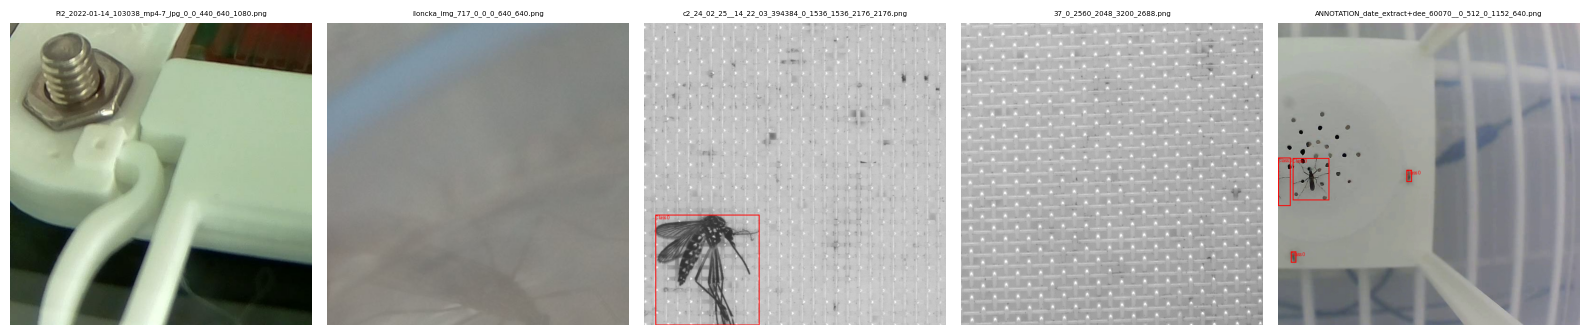

In [60]:
plot_random_images_with_yolo_annotations(f"{yolo_format_dir}/train", num_images=5)

In [3]:
full_dataset_dir = f"{batch_output_directory.replace('/images','/full_dataset')}"
os.makedirs(full_dataset_dir, exist_ok=True)

NameError: name 'batch_output_directory' is not defined

In [62]:
os.system(f"cp -r {yolo_format_dir}/train {full_dataset_dir}")

0

In [63]:
os.system(f"cd {full_dataset_dir} && rsync -a --remove-source-files train/ . > /dev/null 2>&1")

0

In [64]:
os.rmdir(f"{full_dataset_dir}/train")

In [70]:
os.system(f"cp -r {images_train_source} {full_dataset_dir}")
os.system(f"cp -r {images_val_source} {full_dataset_dir}")
os.system(f"cp -r {labels_train_source} {full_dataset_dir}")
os.system(f"cp -r {labels_val_source} {full_dataset_dir}")

0

In [67]:
images_train_source

'/home/bohbot/ultralytics/datasets/mos/all_mos_new/images/train'

In [ ]:
os.system(f"cd {full_dataset_dir} && rsync -a --remove-source-files train/ . > /dev/null 2>&1")
os.system(f"cd {full_dataset_dir} && rsync -a --remove-source-files val/ . > /dev/null 2>&1")

In [64]:
os.rmdir(f"{full_dataset_dir}/train")
os.rmdir(f"{full_dataset_dir}/val")

In [65]:
from sklearn.model_selection import train_test_split

In [27]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

def split_yolo_dataset(data_dir, val_size=0.2, random_state=42):
  """
  Splits images and annotations into train and validation sets for YOLO.

  Args:
    data_dir: Path to the directory containing images and annotations.
    val_size: Proportion of data to use for validation (default: 0.2).
    random_state: Seed for random number generator (default: 42).
  """

  # Get lists of image and annotation files
  image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
  annotation_files = [f.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt') 
                      for f in image_files] 

  # Create empty annotation files if they don't exist
  for annotation_file in annotation_files:
    annotation_path = os.path.join(data_dir, annotation_file)
    if not os.path.exists(annotation_path):
      with open(annotation_path, 'w') as f:
        pass  # Create an empty file
      print(f"Created empty annotation file: {annotation_path}")

  # Split data into train and validation sets
  train_images, val_images, train_annotations, val_annotations = train_test_split(
      image_files, annotation_files, test_size=val_size, random_state=random_state
  )

  # Create necessary directories
  os.makedirs(os.path.join(data_dir, 'images', 'train'), exist_ok=True)
  os.makedirs(os.path.join(data_dir, 'images', 'val'), exist_ok=True)
  os.makedirs(os.path.join(data_dir, 'labels', 'train'), exist_ok=True)
  os.makedirs(os.path.join(data_dir, 'labels', 'val'), exist_ok=True)

  # Copy images and annotations to respective folders
  for image_file, annotation_file in zip(train_images, train_annotations):
    copyfile(os.path.join(data_dir, image_file), os.path.join(data_dir, 'images', 'train', image_file))
    copyfile(os.path.join(data_dir, annotation_file), os.path.join(data_dir, 'labels', 'train', annotation_file))
  

  for image_file, annotation_file in zip(val_images, val_annotations):
    copyfile(os.path.join(data_dir, image_file), os.path.join(data_dir, 'images', 'val', image_file))
    copyfile(os.path.join(data_dir, annotation_file), os.path.join(data_dir, 'labels', 'val', annotation_file))
   


In [29]:
# Example usage:

split_yolo_dataset(full_dataset_dir)

In [31]:
images =  "/home/bohbot/Evyatar/git/crop_sahi/large_images/full_dataset/images"
labels =  "/home/bohbot/Evyatar/git/crop_sahi/large_images/full_dataset/labels"
dataset_path = "/home/bohbot/ultralytics/datasets/mos/mos_crop_update"

In [32]:
os.system(f"mv {images} {labels} {dataset_path}")

0